# Robustness test for GNN on AbAg-Affinity dataset

Use the Kruskal-Wallis test to assert if there is a significant difference in the performance of the GNN for all 4 validation splits.

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
from pathlib import Path
from sklearn.metrics import mean_squared_error 
from scipy.stats import kruskal
from scikit_posthocs import posthoc_dunn
import scipy.stats as stats
import numpy as np

In [2]:

def calc_kruskal_wallis_score(df: pd.DataFrame, target: str, group: str):
    group_values = []
    results = []

    groups = df.groupby(group).groups

    for value, idx in groups.items():
        group_values.append(value)
        results.append(df.loc[idx, target])
        

    kruskal_results = kruskal(*results)
    print(f"Kruskal results for parameter {group}: H={kruskal_results[0]}, p_value={kruskal_results[1]}  ")

    if kruskal_results[1] < 0.05:
        # perform posthoc analyis
        posthoc_results = posthoc_dunn(df, val_col=target, group_col=group)
        print("\tResults of Posthoc analysis with Bonferri correction")
        print(posthoc_results < 0.05)
        
    return kruskal_results, group_values


def get_kruskal_score_statistics_and_plot(df):
    statistics = df.groupby(by="Validation Set during Training").describe()
    sns.boxplot(data=df, y="error [-log(Kd)]", x="Validation Set during Training")
    kruskal_results = calc_kruskal_wallis_score(df, target= "error [-log(Kd)]", group="Validation Set during Training")
    
    return statistics, kruskal_results

In [35]:
project_root = "../.."
plot_path = os.path.join(project_root, "results", "experiments", "Model_Robustness")
Path(plot_path).mkdir(exist_ok=True, parents=True)#


col_mapping = {
    "prediction": "gnn_prediction",
    "labels": "-log(Kd)_labels"
}

validation_sets = []

for i in range(1,11):
    abag_test = pd.read_csv(os.path.join(project_root, f"results/predictions/CV_experiment/abag_affinity_test_cv{i}.csv"), 
                                index_col=0).set_index("pdb").set_axis([f'prediction_val_set_{i}', "label"], axis=1, inplace=False)
    abag_test["dataset"] = "abag_affinity"
    benchmark = pd.read_csv(os.path.join(project_root, f"results/predictions/CV_experiment/benchmark_cv{i}.csv"), 
                                index_col=0).set_index("pdb").set_axis([f'prediction_val_set_{i}', "label"], axis=1, inplace=False)
    benchmark["dataset"] = "benchmark"

    full_testset = pd.concat([abag_test, benchmark])
    validation_sets.append(full_testset)

all_predictions = pd.concat(validation_sets, axis=0)
#all_predictions = all_predictions.loc[:,~all_predictions.columns.duplicated()].copy()

In [36]:
all_errors = []
for col in all_predictions.columns:
    if col in ["label", "dataset"]: continue
    val_sets = ["Set " + col[19:]] * len(all_predictions)
    pdb_ids = all_predictions.index.tolist()
    errors = np.abs(all_predictions[col] - all_predictions["label"]).tolist()
    dataset = all_predictions["dataset"].tolist()
    all_errors.extend(zip(val_sets, dataset, pdb_ids, errors))
                      
all_errors_df = pd.DataFrame(all_errors, columns=["Validation Set during Training", "dataset","pdb_id", "error [-log(Kd)]"])
all_errors_df = all_errors_df[~all_errors_df["error [-log(Kd)]"].isna()]

In [37]:
all_errors_df

,Validation Set during Training,dataset,pdb_id,error [-log(Kd)]
0,Set 1,abag_affinity,1fsk,1.348451
1,Set 1,abag_affinity,1i8i,0.070489
2,Set 1,abag_affinity,1ob1,1.423535
3,Set 1,abag_affinity,1sy6,2.498761
4,Set 1,abag_affinity,1yym,3.424386
...,...,...,...,...
8045,Set 10,benchmark,6a0z,1.222357
8046,Set 10,benchmark,6b0s,1.480805
8047,Set 10,benchmark,6cwg,1.469793
8048,Set 10,benchmark,6dbg,1.197165


Kruskal results for parameter Validation Set during Training: H=17.53349433020162, p_value=0.04098818280624826  
	Results of Posthoc analysis with Bonferri correction
        Set 1  Set 10  Set 2  Set 3  Set 4  Set 5  Set 6  Set 7  Set 8  Set 9
Set 1   False   False  False  False   True  False  False  False   True  False
Set 10  False   False  False  False   True  False  False  False   True  False
Set 2   False   False  False  False   True  False  False  False   True  False
Set 3   False   False  False  False  False  False  False  False  False  False
Set 4    True    True   True  False  False  False  False   True  False  False
Set 5   False   False  False  False  False  False  False   True  False  False
Set 6   False   False  False  False  False  False  False  False  False  False
Set 7   False   False  False  False   True   True  False  False   True  False
Set 8    True    True   True  False  False  False  False   True  False  False
Set 9   False   False  False  False  False  False  Fa

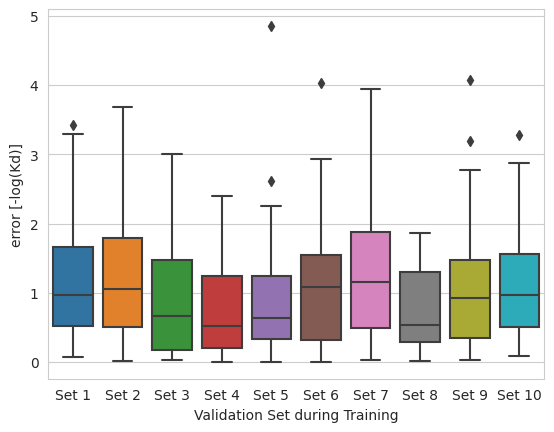

In [40]:
stats, kruskal_score = get_kruskal_score_statistics_and_plot(all_errors_df[all_errors_df["dataset"] == "abag_affinity"])
plt.savefig(os.path.join(plot_path, "abag_affinity_cv_robustness_box_plot.png"))
plt.show()
plt.close()

Kruskal results for parameter Validation Set during Training: H=1.3271187810041738, p_value=0.9982376563480297  


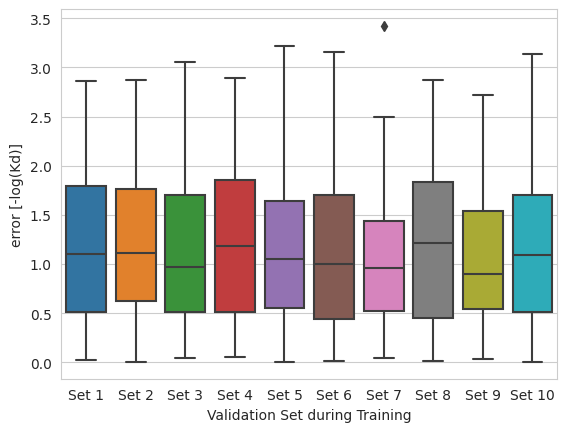

In [41]:
stats, kruskal_score = get_kruskal_score_statistics_and_plot(all_errors_df[all_errors_df["dataset"] == "benchmark"])
plt.savefig(os.path.join(plot_path, "benchmark_csv_robustness_box_plot.png"))
plt.show()
plt.close()